# Analysis_Waterloo-Part4

We will apply machine learning.

In [36]:
import scipy.io

import pandas as pd
import numpy as np
import statistics

import math
import seaborn as sns

import statistics

import re 
from scipy.stats import spearmanr

from platform import python_version
print(python_version())

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

from itertools import combinations_with_replacement, combinations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

3.7.4


In [37]:
data_all = pd.read_pickle("Part3_tmp")

In [38]:
categorical_subset = data_all[['content', 'motion', "Constant_bitrate"]]
mos = data_all["MOS"]
numerical_subset = data_all.copy()
numerical_subset = numerical_subset.drop (["MOS", 'content', 'motion', "Constant_bitrate"], axis = 1)

In [39]:
len (numerical_subset.columns) + len (categorical_subset.columns) 

27

Next we  change names of the categories to numbers

In [40]:
categorical_subset = pd.get_dummies(categorical_subset)

In [41]:
categorical_subset

,content,motion,Constant_bitrate
0,1,2,1
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0
...,...,...,...
445,1,2,0
446,1,2,0
447,1,2,0
448,1,2,0


In [42]:
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = mos

## Stratification
It is common practise in classification tasks.
But very uncommon in regression

Here you can fing a great papar [about it](https://scottclowe.com/2016-03-19-stratified-regression-partitions/) 

In [43]:
columns_save = features.columns

In [44]:
import random
index_test =[]
index_val= []
for i in range(45):
    #random.seed(42) 
    a = random.randint(10*i, 9 + 10*i)
    index_test.append (a)
    #random.seed(24) 
    while (a != 0):
        b = random.randint(10*i, 9 + 10*i)
        if (a!=b):
            a = 0
            index_val.append (b)

In [45]:
print (index_test)
print(index_val)
len(index_val)

[3, 16, 26, 30, 48, 51, 61, 75, 89, 95, 107, 117, 122, 131, 142, 156, 167, 179, 187, 192, 201, 214, 224, 233, 243, 256, 264, 278, 287, 294, 302, 315, 325, 330, 344, 352, 366, 370, 382, 394, 405, 414, 426, 439, 446]
[1, 11, 21, 32, 47, 59, 69, 71, 80, 93, 102, 113, 125, 134, 149, 157, 166, 170, 188, 197, 207, 218, 226, 232, 248, 253, 263, 279, 285, 290, 306, 317, 324, 335, 348, 358, 369, 375, 386, 390, 407, 415, 429, 438, 444]


45

In [46]:
k=10 #Number of folds
n = 45#450/k
k_folds = np.zeros((k,n))
#Sorted by MOS
sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)

X = sorted_features.drop(index_test)
X = X.drop(index_val)
X_test = sorted_features.iloc [index_test]
X_val = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]

In [47]:
print(X.shape)
print(X_test.shape)
print(X_val.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(360, 27)
(45, 27)
(45, 27)
(360, 1)
(45, 1)
(45, 1)


In [48]:
X_with_cols = pd.DataFrame(X, columns = columns_save)

## Models to Evaluate

We will compare five different machine learning models using the great [Scikit-Learn library](http://scikit-learn.org/stable/):

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Again, here I'm focusing on implementation rather than explaining how these work. In addition to Hands-On Machine Learning, another great resource (this one is free online) for reading about machine learning models is [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem! 

Here is what the Scikit-learn documentation [says about the defaults](https://arxiv.org/abs/1309.0238):

    __Sensible defaults__: Whenever an operation requires a user-defined parameter,
    an appropriate default value is defined by the library. The default value
    should cause the operation to be performed in a sensible way (giving a baseline
    solution for the task at hand.)

One of the best parts about scikit-learn is that all models are implemented in an identical manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [49]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [50]:
baseline_guess = np.median(train_labels)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(test_labels, baseline_guess))

The baseline guess is a score of 62.18
Baseline Performance on the test set: MAE = 12.0873


In [51]:
# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Scaling Features

In [52]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
y_val = np.array(val_labels).reshape((-1, ))

In [53]:
# Function to calculate mean absolute error
#def mae(y_true, y_pred):
    #return np.mean(abs(y_true - y_pred))
    
def mae(y_true, y_val, y_pred, y_pred_val):    
    return np.mean(abs(y_true - y_pred)), np.mean(abs(y_val - y_pred_val))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    
    y_pred_val = model.predict(X_val)
    #model_mae = mae(y_test, model_pred)
    model_mae = mae(y_test, y_val, model_pred, y_pred_val)
    
    corr = spearmanr(test_labels, model_pred)
    
    print (round(corr[0],4), corr[1])
    
    # Return the performance metric
    return model_mae, corr[0]

In [54]:
lr = LinearRegression()
lr_mae, corr_lr = fit_and_evaluate(lr)

print('Linear Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

0.8765 3.0302391387109006e-15
Linear Regression Performance: MAE test = 5.4241, MAE val = 5.5399


In [55]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae, corr_svm = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % svm_mae)

0.8761 3.279134099681597e-15
Support Vector Machine Regression Performance: MAE test = 2.5867, MAE val = 1.1972


In [56]:
random_forest = RandomForestRegressor(random_state=42)
random_forest_mae, corr_random_forest = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % random_forest_mae)

0.9647 1.5244036533797742e-26
Random Forest Regression Performance: MAE test = 2.4940, MAE val = 2.4936


In [57]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_mae, corr_gradient_boosted = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % gradient_boosted_mae)

0.9696 6.560138003284705e-28
Gradient Boosted Regression Performance: MAE test = 2.8420, MAE val = 2.2879


In [58]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae, corr_knn = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % knn_mae)

0.8346 1.0559726138304989e-12
K-Nearest Neighbors Regression Performance: MAE test = 6.4281, MAE val = 6.2750


## MOS values updating 

There are a hypothesis that QoE function has a sigmoid nature, like this:

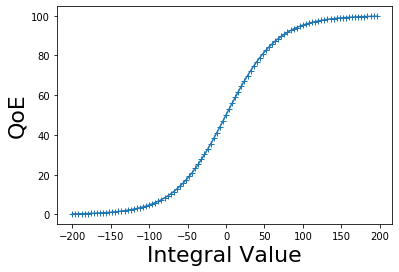

In [73]:
#Sigmoid hypothesis
x = np.arange(-200, 200, 4).tolist()
y = []

b1 = 100 #Scaling factor, constant
b2 = -0.03 #КSlope factor, also can be included in the weights in integral value V
b3 = 200 #Offset along the Ox axis, entered into X itself. 
#x = summ (w.i * xi) - there is some kind of polynomial. b3 - the constant term
#sigma = b1/(b2 + b3*exp(-x))
def sigma(x):
    sigma = 100/(1 + math.exp(b2*(x)))
   
    return sigma

y= list (map(lambda x : sigma(x), x))

fig, ax = plt.subplots()
ax.plot(x, y, '+', linestyle='solid')

plt.xlabel('Integral Value', size = 22);
plt.ylabel('QoE', size = 22);


## But we will see next that it can also be like this: 

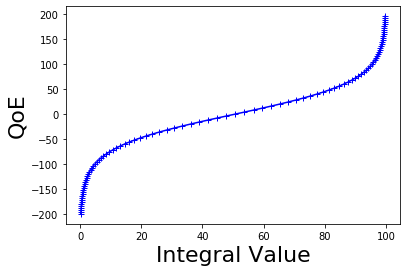

In [75]:
##Logarithmic hypothesis
x = np.arange(-200, 200, 4).tolist()
y = []

b1 = 100 
b2 = -0.03 
b3 = 1 
def sigma(x):
    sigma = -b1/(1 + math.exp(b2*(-x-b3))) + 100
   
    return sigma

y = list (map(lambda x : sigma(x), x))

fig, ax = plt.subplots()
ax.plot(y, x, 'b+', linestyle='solid')
plt.xlabel('Integral Value', size = 22);
plt.ylabel('QoE', size = 22);
plt.show()

In [59]:
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = mos

In [60]:
def transmutation(mos):
    return math.log(mos/(100-mos))

#I also have some ideas that QoE has a logarifmic nature
def transmutation2(mos):
    #return 1/(1+math.exp((12/100)*(50-mos)))
    #return 1/(1+math.exp((0.08)*(50-mos)))
    #return 100/(1+math.exp((0.1)*(40-mos)))

#for index, row in targets.iterrows():
for i in range(len(targets)):
    
    #value = transmutation(row['MOS'])
    #print (value)
    #targets.at[index, 'MOS'] = value
    
    value = transmutation(targets[i])
    targets[i] = value

/home/ksant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
k=10
n = 45#450/k
k_folds = np.zeros((k,n))

sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)

X = sorted_features.drop(index_test)
X = X.drop(index_val)
X_test = sorted_features.iloc [index_test]
X_val = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]

In [62]:
X_with_cols = pd.DataFrame(X, columns = columns_save)

## Scaling Features

In [63]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
y_val = np.array(val_labels).reshape((-1, ))

In [64]:
lr = LinearRegression()
lr_maea, corr_lr_t = fit_and_evaluate(lr)

print('Linear Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_maea)

0.8838 8.897355577615486e-16
Linear Regression Performance: MAE test = 0.2645, MAE val = 0.2524


In [65]:
svm = SVR(C = 1000, gamma = 0.1)
svm_maea, corr_svm_t = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % svm_maea)

0.8808 1.4844706581616397e-15
Support Vector Machine Regression Performance: MAE test = 0.1865, MAE val = 0.1222


In [66]:
random_forest = RandomForestRegressor(random_state=42)
random_forest_maea, corr_random_forest_t = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % random_forest_maea)

0.9692 8.623649163256849e-28
Random Forest Regression Performance: MAE test = 0.1120, MAE val = 0.1028


In [67]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_maea, corr_gradient_boosted_t = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % gradient_boosted_maea)

0.9586 4.324620174860369e-25
Gradient Boosted Regression Performance: MAE test = 0.1258, MAE val = 0.1138


In [68]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_maea, corr_knn_t = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % knn_maea)

0.8343 1.0946852890114698e-12
K-Nearest Neighbors Regression Performance: MAE test = 0.3105, MAE val = 0.2943


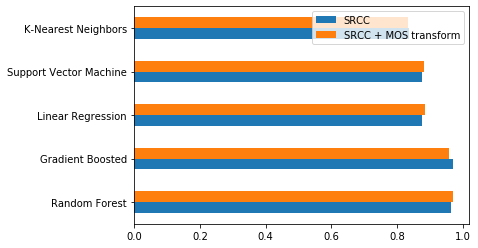

In [69]:
corr = [corr_lr, corr_svm, corr_random_forest, 
                                         corr_gradient_boosted, corr_knn]

corr_t = [corr_lr_t, corr_svm_t, corr_random_forest_t, 
                                         corr_gradient_boosted_t, corr_knn_t]

index = ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors']
df = pd.DataFrame({'SRCC': corr, 'SRCC + MOS transform': corr_t}, index=index)
df=df.sort_values('SRCC + MOS transform', ascending = False)
ax = df.plot.barh()

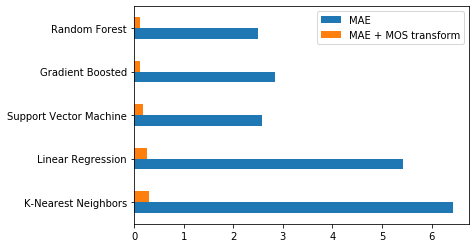

In [70]:
mae = [lr_mae[0], svm_mae[0], random_forest_mae[0], 
                                         gradient_boosted_mae[0], knn_mae[0]]

maes = [lr_maea[0], svm_maea[0], random_forest_maea[0], 
                                         gradient_boosted_maea[0], knn_maea[0]]

index = ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors']
df = pd.DataFrame({'MAE': mae, 'MAE + MOS transform': maes}, index=index)
df=df.sort_values('MAE + MOS transform', ascending = False)
ax = df.plot.barh()

### MOS transmutation
So, we have some increase in terms of MAE and also we have some simplification of models in terms of a number of estimators

In [71]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160,
                170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 
                280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410]

# Maximum depth of each tree
max_depth = [3, 4, 5, 6, 7]

# Minimum number of samples per leaf
min_samples_leaf = [3, 4, 5, 6]

# Minimum number of samples to split a node
min_samples_split = [8, 9, 10, 11, 12, 13, 14]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

#Регяляризация
penalty=['l2', 'l1']

#Параметр регуляризации
alpha = np.linspace(0.0001, 0.01, num = 100)

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [72]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

#scoring_list = ["explained_variance",'neg_mean_absolute_error' ]
from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_validate

#n_splits=5, test_size=.25, random_state=0
#cv = cross_decomposition.ShuffleSplit(train_labels, n_splits = 20, test_size=0.2, random_state=42)
rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=42)
cv = rs.split(train_labels)
# Set up the random search with CV-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=cv, n_iter=5000, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)
                               # refit = False)

#Теперь это полный перебор        
#random_cv = GridSearchCV(estimator=model,
#                               param_grid=hyperparameter_grid,
#                               cv=cv, 
#                               scoring = "neg_mean_absolute_error",
#                               n_jobs = -1, verbose = 1, 
#                               return_train_score = True)
#                               # refit = False)        

In [855]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.6s


KeyboardInterrupt: 